# Classifier
In this notebook, we use the mutational signatures to develop a classifier on the discovery dataset (from Hartwig). We do a detailed evaluation of the model based:
- Accuracy
- Sensitivity
- Specificity
- ROC AUC
- Hazard ratio of predicted label

In addition, we test the model on the validation set [of [Miao _et al._ (2018)](https://www.nature.com/articles/s41588-018-0200-2)] to verify that the model generalizes beyond our dataset.

In [1]:
!mkdir -p figs/

In [74]:
from datetime import timedelta
from functools import reduce

from lifelines import CoxPHFitter, KaplanMeierFitter
from matplotlib import pyplot as plt
from numpy import concatenate, log, nan, sqrt
from pandas import DataFrame, Series, concat, isna, read_csv, to_timedelta
from scipy.stats import fisher_exact, ks_2samp
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline

from statkit.distributions import ZeroInflatedExponential
from statkit.feature_selection import StatisticalTestFilter
from statkit.metrics import sensitivity, specificity
from statkit.naive_bayes import NaiveBayesClassifier
from statkit.non_parametric import (
    bootstrap_score,
    paired_permutation_test,
    unpaired_permutation_test,
)
from statkit.views import format_p_value


In [3]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

In [4]:
from src.statistics import hazard_ratio_test
from utils import (
    X_y,
    plot_kaplan_meier,
    plot_roc_curve,
    polish_variable_names,
    save_plot,
    stratify_survival,
    get_hazard_ratio,
)


## Mutational signature
We have four types of mutational signatures: 
- single base substution signatures
- doublet base substitution signatures
- short insertion and deletion signatures
- and copy number alteration signatures.

In an earlier notebook, where we did the univariate analysis, we found that the single base substitution  (SBS) signatures were the best predictors. Therefore, this will be our focus.
Note that these mutational signatures were computed using the amino-acid changing variants.

Load datasets. Load mutational signatures from the discovery dataset (Hartwig).

In [5]:
# Load signatures
hrtw_signatures = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_hrtw, y_hrtw = X_y(hrtw_signatures)
not_na_hrtw = (~y_hrtw.isna()) # & (X_hrtw.prior_therapy != 'naive')

# Load TMB.
hartwig_tmb = read_csv('../artifacts/hartwig_tmb.tsv', sep='\t', index_col=0)

# And concatenate TMB column to mutational signature data frame.
assert all(hartwig_tmb.index == X_hrtw.index)
X_hrtw['tmb'] = hartwig_tmb['tmb']

And the discovery dataset of Miao _et al._ ('20). 

In [6]:
miao = read_csv('../artifacts/miao_wes_signature.tsv', sep='\t', index_col=0)
X_miao, y_miao = X_y(miao)
not_na_miao = ~y_miao.isna()

In [7]:
def get_low_variance_signatures(data, columns):
    """Columns with zero variance DB or non-DB patients (or both)."""
    is_db = data['durable_benefit'] == 1.0
    db_var = data.loc[is_db, columns].var()
    ndb_var = data.loc[~is_db, columns].var()

    low_variance = set(db_var[db_var == 0].index).union(ndb_var[ndb_var == 0].index)
    return list(low_variance)

The classifier outputs probabilities. To obtain a label, we dichotomise the probability with a cut off point. 
The cut off point is chosen to be the proportion of patients having durable benefit. To prevent overfitting, we estimate the proportion of of durable beniciaries from a similar population but from a previous paper:
[Donker _et al._, 170, 52 Lung Cancer ('22)](https://www.sciencedirect.com/science/article/pii/S0169500222004548)


In [8]:
# Donker et al., Lung Cancer ('22)
# Number of durable benefit:
threshold = 160/365

In [9]:
SBS_columns = [c for c in X_hrtw.columns if c.startswith('SBS')]

## Mutational signature classifier
The supervised task is to use the mutational signatures to classify patients having durable benefit, yes or no. Durable benefit is defined as progression free survival >= 6 months. 
We use a naive Bayes model where the features are zero-inflated exponentials.

In [10]:
def leave_one_out(estimator, X, y):
    """Train a model and predict for each LOO sample."""
    classifiers = []
    y_pred_proba = []
    for train_index, test_index in LeaveOneOut().split(X):
        try:
            clf = estimator.fit(X.iloc[train_index], y[train_index])
            y_proba = clf.predict_proba(X.iloc[test_index])
        except ValueError:
            y_pred_proba.append(nan)
            classifiers.append(None)
        else:
            y_pred_proba.append(y_proba[0])
            classifiers.append(clf)
    return classifiers, DataFrame(y_pred_proba, index=X.index)

In [11]:
def get_selected_features(estimator, X, y):
    """Train LeaveOneOut models, and retrieve selected features."""
    not_na = ~y.isna()
    classifiers, y_proba = leave_one_out(estimator, X[not_na], y[not_na])
    def _features(pipeline):
        if pipeline is not None:
            return set(pipeline['feature_selector'].get_feature_names_out())
        return set()
    
    # Only features selected in all folds.
    features_per_fold = [_features(c) for c in classifiers]
    return list(reduce(lambda a, b: a.intersection(b), features_per_fold))

First, we train a pipeline on the single base substitutions data. The pipeline consists of a:
- a feature selector (StatisticalTestFilter), which does a Kolmogorov-Smirnov test between the labels, and performs false discovery rate control.
- a classifier that performs prediction.

We then run `get_selected_features` which runs leave-one-out cross validation and extracts the significant features (intersection) from the individual folds. In this way, we haven't peeked at the optimal features.

In [12]:
clf_sbs = Pipeline(steps=[
    ('feature_selector',  StatisticalTestFilter()),
    ('classifier', NaiveBayesClassifier(ZeroInflatedExponential)),
])
get_selected_features(clf_sbs, X_hrtw[SBS_columns], y_hrtw)

['SBS4', 'SBS87']

### Verify utility of each variable
By also training the model with only one of the two significant signatures.

In [13]:
clf_sbs87 = NaiveBayesClassifier(ZeroInflatedExponential)


y_hrtw_sbs87_proba = cross_val_predict(
    clf_sbs87,
    X_hrtw.loc[not_na_hrtw, ['SBS87']],
    y_hrtw[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.1s finished


In [14]:
clf_sbs4 = NaiveBayesClassifier(ZeroInflatedExponential)


y_hrtw_sbs4_proba = cross_val_predict(
    clf_sbs4,
    X_hrtw.loc[not_na_hrtw, ['SBS4']],
    y_hrtw[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.1s finished


Our final selection is composed of:
- SBS4
- SBS87

and these will be the input to our model.

Next, we repeat the leave-one-out cross validation. Now, the goal is to make predictions on all hold out samples. This ensures that we are not overfitting on the data.

In [15]:
print('Analysing n =', y_hrtw[not_na_hrtw].shape[0], 'patients')

Analysing n = 93 patients


In [16]:
features = ['SBS4', 'SBS87']
clf = NaiveBayesClassifier(ZeroInflatedExponential)


y_hrtw_proba = cross_val_predict(
    clf,
    X_hrtw.loc[not_na_hrtw, features],
    y_hrtw[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.1s finished


In this figure, we compare the model with:
- SBS87 only
- SBS4 only
- Both SBS4 and SBS87.

In [17]:
ax = plot_roc_curve(y_hrtw[not_na_hrtw], y_hrtw_sbs87_proba, 'SBS87')
ax = plot_roc_curve(y_hrtw[not_na_hrtw], y_hrtw_sbs4_proba, 'SBS4', ax=ax)
plot_roc_curve(y_hrtw[not_na_hrtw], y_hrtw_proba, 'SBS87 + SBS4', ax=ax)
ax.plot([0, 1], [0, 1], "--", color="r", linewidth=2, label="Random (AUC: 0.5)")
plt.title('Discovery set')
save_plot('roc/discovery-signatures')

Next, perform inference on Miao _et al._ validation set. We therefore re-train on the entire Hartwig dataset (on the labelled samples) prior to prediction.

In [18]:
# Train classifiers on Hartwig data.
# Full model consisting of SBS4 + SBS87.
clf.fit(X_hrtw.loc[not_na_hrtw, features], y_hrtw[not_na_hrtw])
# Model with only SBS87.
clf_sbs87.fit(X_hrtw.loc[not_na_hrtw, ['SBS87']], y_hrtw[not_na_hrtw])
# Model with only SBS4.
clf_sbs4.fit(X_hrtw.loc[not_na_hrtw, ['SBS4']], y_hrtw[not_na_hrtw])

y_miao_proba = clf.predict_proba(X_miao[features]).iloc[:,1]

Dichotomise predicted probabilities to class labels.

In [19]:
y_hrtw_pred = (y_hrtw_proba >= threshold).astype(int)
y_miao_pred = (y_miao_proba >= threshold).astype(int)

Keep track of performance scores.

In [20]:
scores = DataFrame(
    index=["Discovery (Hartwig DR #094)", "Validation [Miao et al. ('18)]", "p"],
    columns=[
        "ROC AUC",
        "AP",
        "$F_1$",
        "Sensitivity",
        "Specificity",
        "Accuracy",
        "$h_r$",
    ],
)


In [21]:
hartwig_auc = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_proba, metric=roc_auc_score)
print('ROC AUC discovery set:', hartwig_auc)
print(hartwig_auc.latex())
scores.loc['Discovery (Hartwig DR #094)', 'ROC AUC'] = hartwig_auc.latex()

ROC AUC discovery set: 0.74 (95 % CI: 0.63-0.84)
0.74$^{+0.10}_{-0.11}$


In [22]:
miao_auc = bootstrap_score(y_miao[not_na_miao], y_miao_proba[not_na_miao], metric=roc_auc_score)
print('ROC AUC validation set:', miao_auc)
print(miao_auc.latex())
scores.loc["Validation [Miao et al. ('18)]", 'ROC AUC'] = miao_auc.latex()

ROC AUC validation set: 0.69 (95 % CI: 0.54-0.83)
0.69$^{+0.14}_{-0.14}$


In [23]:
p_value = unpaired_permutation_test(
    # Dsicovery set.
    y_hrtw[not_na_hrtw],
    y_hrtw_proba,
    # Validation set.
    y_miao[not_na_miao],
    y_miao_proba[not_na_miao],
    metric=roc_auc_score,
)
print('Significantly different: p =', format_p_value(p_value, format='compact'), 'unpaired permutation test')
scores.loc['p', 'ROC AUC'] = format_p_value(p_value, format='compact')

Significantly different: p = $0.57$ unpaired permutation test


### Average precision
Precision is defined in terms of all predicted positives:
$$precision = tp / pp$$.
The average precision score is essentially the curve under the precision-recall curve.

In [24]:
hartwig_ap = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_proba, metric=average_precision_score)
print('Hartwig: Average precision:', hartwig_ap)
print(hartwig_ap.latex())
scores.loc['Discovery (Hartwig DR #094)', 'AP'] = hartwig_ap.latex()

miao_ap = bootstrap_score(y_miao[not_na_miao], y_miao_proba[not_na_miao], metric=average_precision_score)
print('Miao et al.: Average precision:', miao_ap)
print(miao_ap.latex())
scores.loc["Validation [Miao et al. ('18)]", 'AP'] = miao_ap.latex()

Hartwig: Average precision: 0.63 (95 % CI: 0.49-0.81)
0.63$^{+0.18}_{-0.14}$
Miao et al.: Average precision: 0.71 (95 % CI: 0.55-0.88)
0.71$^{+0.17}_{-0.17}$


In [25]:
p_value = unpaired_permutation_test(
    y_hrtw[not_na_hrtw],
    y_hrtw_proba, 
    y_miao[not_na_miao], 
    y_miao_proba[not_na_miao], 
    metric=average_precision_score,
)
print('Significantly different: p =', format_p_value(p_value, format='compact'), 'unpaired permutation test')
scores.loc['p', 'AP'] = format_p_value(p_value, format='compact')

Significantly different: p = $0.56$ unpaired permutation test


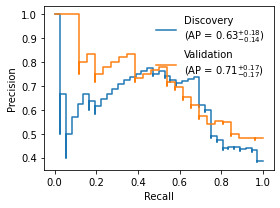

In [26]:
f = plt.figure(figsize=(4,3))
ax = f.gca()

# Hartwig
display_sign = PrecisionRecallDisplay.from_predictions(
    y_hrtw[not_na_hrtw], 
    y_hrtw_proba, 
    name='Hartwig\n', 
    ax=ax
)
ax.lines[-1].set_label('Discovery\n(AP = {})'.format(hartwig_ap.latex()))

# Miao
display_sign = PrecisionRecallDisplay.from_predictions(
    y_miao[not_na_miao], 
    y_miao_proba[not_na_miao], 
    name='Miao et al.\n', 
    ax=ax
)
ax.lines[-1].set_label("Validation\n(AP = {})".format(miao_ap.latex()))

plt.legend(frameon=False, loc='upper right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
save_plot('precision-recall-signature')

### Calibration plot

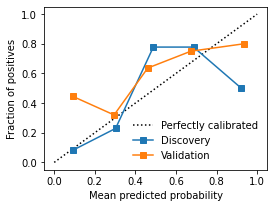

In [27]:
f = plt.figure(figsize=(4,3))
ax = f.gca()
display_sign = CalibrationDisplay.from_predictions(
    y_hrtw[not_na_hrtw],
    y_hrtw_proba, 
    name='Discovery',  
    ax=ax, 
)

display_sign = CalibrationDisplay.from_predictions(
    y_miao[not_na_miao], 
    y_miao_proba[not_na_miao], 
    name="Validation",
    ax=ax,
)

plt.legend(frameon=False)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
save_plot('calibration-signature')

### $F_1$ score
This metrics balances precision and recall.

In [28]:
print('Hartwig: F_1 score')
hrtwg_f1 = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_pred, metric=f1_score)
print(hrtwg_f1)
print(hrtwg_f1.latex())
scores.loc['Discovery (Hartwig DR #094)', '$F_1$'] = hrtwg_f1.latex()

print("Miao et al. ('18): F_1 score")
miao_f1 = bootstrap_score(y_miao[not_na_miao], y_miao_pred[not_na_miao], metric=f1_score)
print(miao_f1)
print(miao_f1.latex())
scores.loc["Validation [Miao et al. ('18)]", '$F_1$'] = miao_f1.latex()

Hartwig: F_1 score
0.63 (95 % CI: 0.48-0.75)
0.63$^{+0.12}_{-0.14}$
Miao et al. ('18): F_1 score
0.57 (95 % CI: 0.38-0.73)
0.57$^{+0.16}_{-0.19}$


In [29]:
p_value = unpaired_permutation_test(
    y_hrtw[not_na_hrtw],
    y_hrtw_pred, 
    y_miao[not_na_miao], 
    y_miao_pred[not_na_miao], 
    metric=f1_score,
)
print('F_1 score, significantly different: p =', format_p_value(p_value, format='compact'), 'UPT')
scores.loc['p', '$F_1$'] = format_p_value(p_value, format='compact')

F_1 score, significantly different: p = $0.67$ UPT


### Accuracy

In [30]:
print('Discovery: Accuracy')
hrtwg_acc = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_pred, metric=accuracy_score)
print(hrtwg_acc)
print(hrtwg_acc.latex())
scores.loc['Discovery (Hartwig DR #094)', 'Accuracy'] = hrtwg_acc.latex()

tn, fp, fn, tp = confusion_matrix(y_hrtw[not_na_hrtw], y_hrtw_pred).ravel()
print(f'Of which {fp} false positive and {fn} false negatives.')

Discovery: Accuracy
0.74 (95 % CI: 0.66-0.84)
0.74$^{+0.10}_{-0.09}$
Of which 8 false positive and 16 false negatives.


In [31]:
print("Validation: Accuracy")
miao_acc = bootstrap_score(y_miao[not_na_miao], y_miao_pred[not_na_miao], metric=accuracy_score)
print(miao_acc)
print(miao_acc.latex())
scores.loc["Validation [Miao et al. ('18)]", 'Accuracy'] = miao_acc.latex()

tn, fp, fn, tp = confusion_matrix(y_miao[not_na_miao], y_miao_pred[not_na_miao]).ravel()
print(f'Of which {fp} false positive and {fn} false negatives.')

Validation: Accuracy
0.67 (95 % CI: 0.52-0.80)
0.67$^{+0.13}_{-0.15}$
Of which 4 false positive and 14 false negatives.


In [32]:
p_value = unpaired_permutation_test(
    y_hrtw[not_na_hrtw],
    y_hrtw_pred, 
    y_miao[not_na_miao], 
    y_miao_pred[not_na_miao], 
    metric=accuracy_score,
)
print('Accuracy, significantly different discovery from validation: p =', format_p_value(p_value, format='compact'), 'UPT')
scores.loc['p', 'Accuracy'] = format_p_value(p_value, format='compact')

Accuracy, significantly different discovery from validation: p = $0.34$ UPT


### Sensitivity

In [33]:
print('Hartwig: Sensitivity')
hrtw_sensitivity = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_pred, metric=sensitivity)
print(hrtw_sensitivity)
print(hrtw_sensitivity.latex())
scores.loc['Discovery (Hartwig DR #094)', 'Sensitivity'] = hrtw_sensitivity.latex()

print('Miao: Sensitivitiy')
miao_sensitivity = bootstrap_score(y_miao[not_na_miao], y_miao_pred[not_na_miao], metric=sensitivity)
print(miao_sensitivity)
print(miao_sensitivity.latex())
scores.loc["Validation [Miao et al. ('18)]", 'Sensitivity'] = miao_sensitivity.latex()

Hartwig: Sensitivity
0.56 (95 % CI: 0.39-0.72)
0.56$^{+0.16}_{-0.17}$
Miao: Sensitivitiy
0.46 (95 % CI: 0.27-0.65)
0.46$^{+0.19}_{-0.19}$


In [34]:
p_value = unpaired_permutation_test(
    y_hrtw[not_na_hrtw],
    y_hrtw_pred, 
    y_miao[not_na_miao], 
    y_miao_pred[not_na_miao], 
    metric=sensitivity,
)
print('Sensitivity, significantly different: p =', format_p_value(p_value, format='compact'), 'UPT')
scores.loc['p', 'Sensitivity'] = format_p_value(p_value, format='compact')

Sensitivity, significantly different: p = $0.51$ UPT


In [35]:
print('Hartwig: Specificity')
hrtw_specificity = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_pred, metric=specificity)
print(hrtw_specificity)
print(hrtw_specificity.latex())
scores.loc['Discovery (Hartwig DR #094)', 'Specificity'] = hrtw_specificity.latex()

print('Miao: Specificity')
miao_specificity = bootstrap_score(y_miao[not_na_miao], y_miao_pred[not_na_miao], metric=specificity)
print(miao_specificity)
print(miao_specificity.latex())
scores.loc["Validation [Miao et al. ('18)]", 'Specificity'] = miao_specificity.latex()

Hartwig: Specificity
0.86 (95 % CI: 0.77-0.94)
0.86$^{+0.08}_{-0.09}$
Miao: Specificity
0.86 (95 % CI: 0.72-0.97)
0.86$^{+0.11}_{-0.14}$


In [36]:
p_value = unpaired_permutation_test(
    y_hrtw[not_na_hrtw],
    y_hrtw_pred, 
    y_miao[not_na_miao], 
    y_miao_pred[not_na_miao], 
    metric=specificity,
)
print('Specificity, significantly different: p =', format_p_value(p_value, format='compact'), 'UPT')
scores.loc['p', 'Specificity'] = format_p_value(p_value, format='compact')

Specificity, significantly different: p = $1.0$ UPT


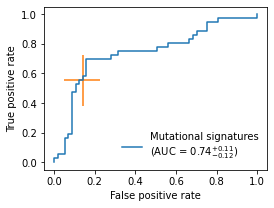

In [37]:
plot_roc_curve(y_hrtw[not_na_hrtw], y_hrtw_proba, name='Mutational signatures', threshold_probability=threshold)
save_plot('roc/discovery')

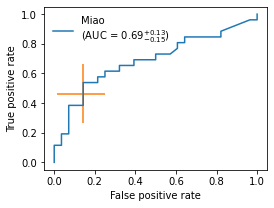

In [38]:
# Show performance on Miao.
plot_roc_curve(y_miao[not_na_miao], y_miao_proba[not_na_miao], name='Miao', threshold_probability=threshold)
save_plot('roc/validation')

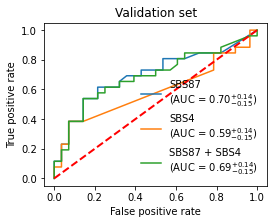

In [39]:
# Do hold out predictions of the univariate models on the validation set.
y_miao_sbs87_proba = clf_sbs87.predict_proba(X_miao[['SBS87']]).iloc[:, 1]
y_miao_sbs4_proba = clf_sbs4.predict_proba(X_miao[['SBS4']]).iloc[:, 1]

ax = plot_roc_curve(y_miao[not_na_miao], y_miao_sbs87_proba[not_na_miao], 'SBS87')
ax = plot_roc_curve(y_miao[not_na_miao], y_miao_sbs4_proba[not_na_miao], 'SBS4', ax=ax)
plot_roc_curve(y_miao[not_na_miao], y_miao_proba[not_na_miao], 'SBS87 + SBS4', ax=ax)
ax.plot([0, 1], [0, 1], "--", color="r", linewidth=2, label="Random (AUC: 0.5)")
plt.title('Validation set')
save_plot('roc/validation-signatures')

## Survival analysis

For the Hartwig dataset, make leave one-out predictions for the training set, and add patients with insufficient follow up. Stratify by predicted outcome.

In [40]:
# Predict on unlabelled Hartwig data.
y_pred_na = clf.predict_proba(X_hrtw.loc[~not_na_hrtw, features])

In [41]:
# Finally, combine the labelled and unlabelled samples.
index = concatenate([X_hrtw[not_na_hrtw].index, X_hrtw[~not_na_hrtw].index], axis=0)
y_hrtw_all_proba = concat(
    [Series(y_hrtw_proba, index=X_hrtw[not_na_hrtw].index), y_pred_na.iloc[:, 1]],
    axis="rows",
)
stratum = y_hrtw_all_proba >= threshold

pfs_hrtw = stratify_survival(
    stratum, X_hrtw.loc[index, "pfs_weeks"], X_hrtw.loc[index, "pfs_event"]
)


Only perform inference on the Miao dataset.

In [42]:
pfs_miao = stratify_survival(y_miao_pred.astype(bool), X_miao['pfs_weeks'], X_miao['pfs_event'])

Median survival Signatures - : 11.142857142857142
Median survival Signatures + : 62.0
Hazard ratio $h_r=0.40^{+0.28}_{-0.17}$ ($p = 8.0 \cdot 10^{-4}$)


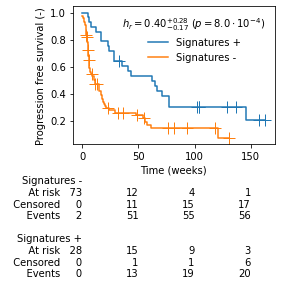

In [43]:
label_db = 'Signatures +'
label_ndb = 'Signatures -'
hazard_ratio_hrtw = plot_kaplan_meier(pfs_hrtw, labels=[label_ndb, label_db])
scores.loc['Discovery (Hartwig DR #094)', '$h_r$'] = hazard_ratio_hrtw.latex()
save_plot('pfs/discovery')

Median survival Signatures - : 15.857142857142858
Median survival Signatures + : 63.0
Hazard ratio $h_r=0.24^{+0.31}_{-0.14}$ ($p = 8.3 \cdot 10^{-4}$)


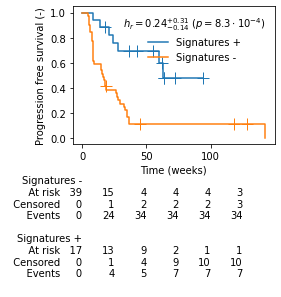

In [44]:
label_db = 'Signatures +'
label_ndb = 'Signatures -'
hazard_ratio_miao = plot_kaplan_meier(pfs_miao, labels=[label_ndb, label_db])
scores.loc["Validation [Miao et al. ('18)]", '$h_r$'] = hazard_ratio_miao.latex()
save_plot('pfs/validation')

Test if the hazard ratio is significantly different by performing a regression coefficient test on the log hazard ratios.

In [45]:
z, p = hazard_ratio_test(hazard_ratio_hrtw, hazard_ratio_miao)
print(format_p_value(p, latex=False, symbol='p', format='compact'))
print(format_p_value(p, latex=True, symbol='p', format='compact'))
scores.loc['p', '$h_r$'] = format_p_value(p, latex=True, format='compact')

p = 0.32
$p = 0.32$


In [46]:
print(scores.to_latex(escape=False))
scores

\begin{tabular}{llllllll}
\toprule
{} &                 ROC AUC &                      AP &                   $F_1$ &             Sensitivity &             Specificity &                Accuracy &                   $h_r$ \\
\midrule
Discovery (Hartwig DR #094)    &  0.74$^{+0.10}_{-0.11}$ &  0.63$^{+0.18}_{-0.14}$ &  0.63$^{+0.12}_{-0.14}$ &  0.56$^{+0.16}_{-0.17}$ &  0.86$^{+0.08}_{-0.09}$ &  0.74$^{+0.10}_{-0.09}$ &  0.40$^{+0.28}_{-0.17}$ \\
Validation [Miao et al. ('18)] &  0.69$^{+0.14}_{-0.14}$ &  0.71$^{+0.17}_{-0.17}$ &  0.57$^{+0.16}_{-0.19}$ &  0.46$^{+0.19}_{-0.19}$ &  0.86$^{+0.11}_{-0.14}$ &  0.67$^{+0.13}_{-0.15}$ &  0.24$^{+0.31}_{-0.14}$ \\
p                              &                  $0.57$ &                  $0.56$ &                  $0.67$ &                  $0.51$ &                   $1.0$ &                  $0.34$ &                  $0.32$ \\
\bottomrule
\end{tabular}



ROC AUC  \
Discovery (Hartwig DR #094)     0.74$^{+0.10}_{-0.11}$   
Validation [Miao et al. ('18)]  0.69$^{+0.14}_{-0.14}$   
p                                               $0.57$   

                                                    AP  \
Discovery (Hartwig DR #094)     0.63$^{+0.18}_{-0.14}$   
Validation [Miao et al. ('18)]  0.71$^{+0.17}_{-0.17}$   
p                                               $0.56$   

                                                 $F_1$  \
Discovery (Hartwig DR #094)     0.63$^{+0.12}_{-0.14}$   
Validation [Miao et al. ('18)]  0.57$^{+0.16}_{-0.19}$   
p                                               $0.67$   

                                           Sensitivity  \
Discovery (Hartwig DR #094)     0.56$^{+0.16}_{-0.17}$   
Validation [Miao et al. ('18)]  0.46$^{+0.19}_{-0.19}$   
p                                               $0.51$   

                                           Specificity  \
Discovery (Hartwig DR #094)     0.86$^{+0.08}_{-0.09}$   
Validation [Miao et al. ('18)]  0.86$^{+0.11}_{-0.14}$   
p                                                $1.0$   

                                              Accuracy                   $h_r$  
Discovery (Hartwig DR #094)     0.74$^{+0.10}_{-0.09}$  0.40$^{+0.28}_{-0.17}$  
Validation [Miao et al. ('18)]  0.67$^{+0.13}_{-0.15}$  0.24$^{+0.31}_{-0.14}$  
p                                               $0.34$                  $0.32$

### Prediction summary
Generate a table where for each patient we indicate the:
- predicted probability
- predicted label
- actual label
- and whether it is a true positive or true negative

In [47]:
def label_prediction(y_true, y_pred):
    if isna(y_true):
        return 'undefined'
    if y_true == 1:
        if y_pred == 1:
            return 'TP'
        else:
            return 'FN'
    elif y_true == 0:
        if y_pred == 1:
            return 'FP'
    return 'TN'

In [48]:
def summarise_predictions(y_true: Series, y_pred_proba: Series) -> DataFrame:
    table = []
    for idx, proba in y_pred_proba.iteritems():
        prediction = int(proba >= threshold)
        label = label_prediction(y_true.loc[idx], prediction)
        row = [idx, y_true.loc[idx], proba, prediction, label]
        table.append(row)
    
    return DataFrame(table, columns=['patient_id', 'durable benefit', 'predicted probability', 'predicted class', 'correct']).set_index('patient_id')

Write to disk.

In [49]:
summarise_predictions(y_hrtw, y_hrtw_all_proba).to_csv('supporting_material/discovery_predictions.csv')
summarise_predictions(y_miao, y_miao_proba).to_csv('supporting_material/validation_predictions.csv')

# TMB
Compare tumor mutation burden with signature model.
Two types of analyses:
1. Train classifier on tumor mutational burden and use same classification threshold as for the mutational signature classifier.
2. Directly dichotomise TMB at TMB >= 10 mutations/mb to classify patients.

### Discovery dataset Hartwig
First do analysis 1 (trained model).

In [50]:
clf_tmb = NaiveBayesClassifier(ZeroInflatedExponential)

y_hrtw_tmb_proba = cross_val_predict(
    clf_tmb,
    X_hrtw.loc[not_na_hrtw, ['tmb']],
    y_hrtw[not_na_hrtw],
    cv=LeaveOneOut(),
    method='predict_proba',
    verbose=1,
)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.2s finished


Receiver operating characteristic analysis of the TMB classifier.

In [51]:
tmb_auc = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_tmb_proba, metric=roc_auc_score)
print('ROC AUC')
print(tmb_auc)
print(tmb_auc.latex())

ROC AUC
0.65 (95 % CI: 0.53-0.76)
0.65$^{+0.11}_{-0.12}$


Is there a significant difference between the ROC AUC score of the mutational signature model, and that of the TMB model?

In [52]:
p_value_sign_vs_tmb_hrtw = paired_permutation_test(
    y_hrtw[not_na_hrtw], y_hrtw_proba, y_hrtw_tmb_proba,
    metric=roc_auc_score,
)
print('ROC AUC, significantly different: p =', format_p_value(p_value_sign_vs_tmb_hrtw), 'PPT')

ROC AUC, significantly different: p = $2.2 \cdot 10^{-2}$ PPT


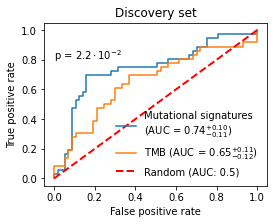

In [53]:
f = plt.figure(figsize=(4, 3))
ax = f.gca()
display_sign = RocCurveDisplay.from_predictions(
    y_hrtw[not_na_hrtw], y_hrtw_proba, name="Mutational signatures\n", ax=ax
)
ax.lines[-1].set_label("Mutational signatures\n(AUC = {})".format(hartwig_auc.latex()))

display_tmb = RocCurveDisplay.from_predictions(
    y_hrtw[not_na_hrtw], y_hrtw_tmb_proba, name="TMB", ax=ax
)
ax.lines[-1].set_label("TMB (AUC = {})".format(tmb_auc.latex()))

ax.plot([0, 1], [0, 1], "--", color="r", linewidth=2, label="Random (AUC: 0.5)")

plt.legend(frameon=False)
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("Discovery set")
plt.text(0.0, 0.8, "p = " + format_p_value(p_value_sign_vs_tmb_hrtw))
save_plot("roc/discovery-signature-vs-tmb")


In [54]:
tmb_ap = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_tmb_proba, metric=average_precision_score)
print('Average precision')
print(tmb_ap)
print(tmb_ap.latex())

Average precision
0.57 (95 % CI: 0.43-0.73)
0.57$^{+0.16}_{-0.14}$


In [55]:
print('F_1 score')
tmb_f1 = bootstrap_score(y_hrtw[not_na_hrtw], y_hrtw_tmb_proba >= threshold, metric=f1_score)
print(tmb_f1)
print(tmb_f1.latex())

F_1 score
0.41 (95 % CI: 0.22-0.56)
0.41$^{+0.15}_{-0.19}$


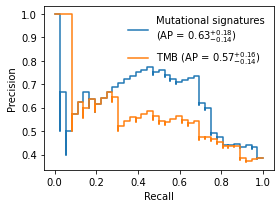

In [56]:
f = plt.figure(figsize=(4, 3))
ax = f.gca()
# Mutational signature classifier.
display_sign = PrecisionRecallDisplay.from_predictions(
    y_hrtw[not_na_hrtw], y_hrtw_proba, name="Mutational signatures\n", ax=ax
)
ax.lines[-1].set_label("Mutational signatures\n(AP = {})".format(hartwig_ap.latex()))

# Tumor mutation burden classifier.
display_tmb = PrecisionRecallDisplay.from_predictions(
    y_hrtw[not_na_hrtw], y_hrtw_tmb_proba, name="TMB", ax=ax
)
ax.lines[-1].set_label("TMB (AP = {})".format(tmb_ap.latex()))

plt.legend(frameon=False)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.tight_layout()
save_plot("precision-recall-signature-vs-tmb")


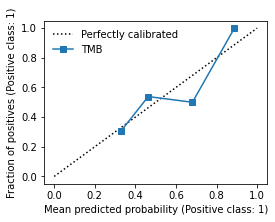

In [57]:
f = plt.figure(figsize=(4,3))
ax = f.gca()
display_tmb = CalibrationDisplay.from_predictions(y_hrtw[not_na_hrtw], y_hrtw_tmb_proba, name='TMB', ax=ax)
plt.legend(frameon=False)

In [58]:
# Make predictions on unlabelled patients that were censored prior to the half year mark.
clf_tmb.fit(X_hrtw.loc[not_na_hrtw, ['tmb']], y_hrtw[not_na_hrtw])
y_tmb_pred_na = clf_tmb.predict_proba(X_hrtw.loc[~not_na_hrtw, ['tmb']])

In [59]:
# Finally, combine the labelled and unlabelled samples.
y_hrtw_tmb_all_proba = concat(
    [
        Series(y_hrtw_tmb_proba, index=X_hrtw[not_na_hrtw].index),
        y_tmb_pred_na.iloc[:, 1],
    ],
    axis="rows",
)

# Two ways of stratifying:
# 1) Train classifier and predict.
# 2) Use TMB >= 10 mb^{-1} threshold.
reindexed = y_hrtw_tmb_all_proba.index
tmb_proba_stratum = y_hrtw_tmb_all_proba >= threshold

pfs_hrtw_proba_tmb = stratify_survival(
    tmb_proba_stratum,
    X_hrtw.loc[reindexed, "pfs_weeks"],
    X_hrtw.loc[reindexed, "pfs_event"],
)


Compute hazard ratio and make Kaplan-Meier plot.

In [60]:
hr_hrtw_proba, p_value_hrtw_proba = get_hazard_ratio(pfs_hrtw_proba_tmb)
print(hr_hrtw_proba, f'(p={p_value_hrtw_proba:.1E})')
print(hr_hrtw_proba.latex(), '(p={})'.format(format_p_value(p_value_hrtw_proba, latex=True)))

0.61 (95 % CI: 0.34-1.1) (p=1.0E-01)
0.61$^{+0.49}_{-0.27}$ (p=$1.0 \cdot 10^{-1}$)


Median survival tmb - : 14.857142857142858
Median survival tmb + : 62.0
Hazard ratio $h_r=0.61^{+0.49}_{-0.27}$ ($p = 1.0 \cdot 10^{-1}$)


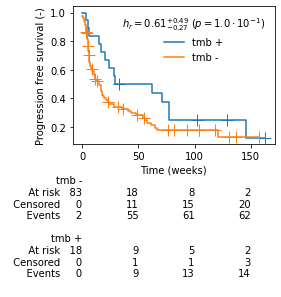

In [61]:
plot_kaplan_meier(pfs_hrtw_proba_tmb, labels=['tmb -', 'tmb +'])
save_plot('pfs/discovery-tmb-parametric')

### Classifier type 2.
Dichotomise TMB >= 10 mutations/mb to classify patients.

In [62]:
tmb_10_stratum = X_hrtw.loc[reindexed, "tmb"] >= 10
pfs_hrtw_10_tmb = stratify_survival(
    tmb_10_stratum,
    X_hrtw.loc[reindexed, "pfs_weeks"],
    X_hrtw.loc[reindexed, "pfs_event"],
)

In [63]:
hr_hrtw_10, p_value_hrtw_10 = get_hazard_ratio(pfs_hrtw_10_tmb)
print(hr_hrtw_10, f'(p={p_value_hrtw_10:.1E})')
print(hr_hrtw_10.latex(), '(p={})'.format(format_p_value(p_value_hrtw_10, latex=True)))

0.57 (95 % CI: 0.33-0.99) (p=4.7E-02)
0.57$^{+0.42}_{-0.24}$ (p=$4.7 \cdot 10^{-2}$)


So it seems that the >= 10 TMB threshold is a bit better predictor than the trained classifier.

Median survival tmb - : 12.0
Median survival tmb + : 28.0
Hazard ratio $h_r=0.57^{+0.42}_{-0.24}$ ($p = 4.7 \cdot 10^{-2}$)


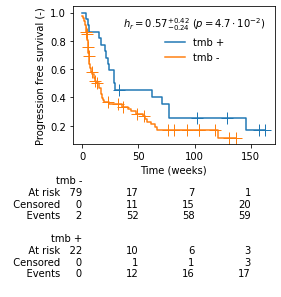

In [64]:
plot_kaplan_meier(pfs_hrtw_10_tmb, labels=['tmb -', 'tmb +'])
save_plot('pfs/discovery-tmb-10mb')

Statistical test to compare:
- hazard ratio of mutational signature classifier
- hazard ratio of classifier trained on TMB.

In [65]:
hazard_ratio_test(hazard_ratio_hrtw, hr_hrtw_proba)

(1.033142163524863, 0.3015373742648504)

**Conclusion**: Not significant.

Statistical test to compare:
- hazard ratio of mutational signature classifier
- hazard ratio of TMB dichotomised at TMB >= 10.

In [66]:
hazard_ratio_test(hazard_ratio_hrtw, hr_hrtw_10)

(0.8821051133204308, 0.3777199673266063)

**Conclusion**: Not significant.

# Miao

In [67]:
X_miao['tmb_raw'] = X_miao.pop('tmb')  # Rename columns to prevent schema skew exception.
X_miao['tmb'] = X_miao['tmb_raw'] / X_miao['region covered (mb)']
y_miao_tmb_proba = clf_tmb.predict_proba(X_miao[['tmb']]).iloc[:, 1]

In [68]:
miao_tmb_auc = bootstrap_score(y_miao[not_na_miao], y_miao_tmb_proba[not_na_miao], metric=roc_auc_score)
print('ROC AUC')
print(miao_tmb_auc)
print(miao_tmb_auc.latex())

ROC AUC
0.78 (95 % CI: 0.65-0.89)
0.78$^{+0.11}_{-0.13}$


In [69]:
p_value_sign_vs_tmb_miao = paired_permutation_test(
    y_miao[not_na_miao], y_miao_proba[not_na_miao], y_miao_tmb_proba[not_na_miao],
    metric=roc_auc_score,
)
print('ROC AUC, significantly different: p =', format_p_value(p_value_sign_vs_tmb_miao), 'PPT')

ROC AUC, significantly different: p = $0.21$ PPT


**Conclusion**: Not significant. The area under the ROC curves are not significantly different. 

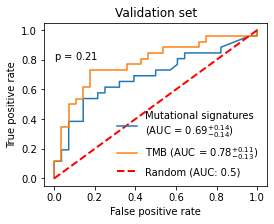

In [70]:
f = plt.figure(figsize=(4, 3))
ax = f.gca()
# ROC curve of Hartwig-trained mutational signature classifier.
display_sign = RocCurveDisplay.from_predictions(
    y_miao[not_na_miao],
    y_miao_proba[not_na_miao],
    name="Mutational signatures\n",
    ax=ax,
)
ax.lines[-1].set_label("Mutational signatures\n(AUC = {})".format(miao_auc.latex()))
# ROC curve of Hartwig-trained TMB classifier.
display_tmb = RocCurveDisplay.from_predictions(
    y_miao[not_na_miao], y_miao_tmb_proba[not_na_miao], name="TMB", ax=ax
)
ax.lines[-1].set_label("TMB (AUC = {})".format(miao_tmb_auc.latex()))

ax.plot([0, 1], [0, 1], "--", color="r", linewidth=2, label="Random (AUC: 0.5)")

plt.legend(frameon=False)
plt.title("Validation set")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.text(0.0, 0.8, "p = " + format_p_value(p_value_sign_vs_tmb_miao))
save_plot("roc/validation-signature-vs-tmb")


### Rationale
Can we understand why TMB is now slightly better than the signatures?

**Hypothesis**: the distribution of TMB in the discovery cohort is different from the validation cohort..

In [81]:
_, p_tmb = ks_2samp(X_hrtw['tmb'], X_miao['tmb'])
print('Is TMB different in discovery and validation set?')
print('Yes ({}, KS test)'.format(format_p_value(p_tmb, format='compact', symbol='p')))

Is TMB different in discovery and validation set?
Yes ($p = 0.031$, KS test)


Is the distribution of SBS4 and SBS87 significantly different between the discovery and validation cohorts? 

In [83]:
_, p_sbs4 = ks_2samp(X_hrtw['SBS4'], X_miao['SBS4'])
print('Is SBS4 different in discovery and validation set?')
print('No ({}, KS test)'.format(format_p_value(p_sbs4, format='compact', symbol='p')))

_, p_sbs87 = ks_2samp(X_hrtw['SBS87'], X_miao['SBS87'])
print('Is SBS87 different in discovery and validation set?')
print('No ({}, KS test)'.format(format_p_value(p_sbs87, format='compact', symbol='p')))

Is SBS4 different in discovery and validation set?
No ($p = 0.082$, KS test)
Is SBS87 different in discovery and validation set?
No ($p = 0.69$, KS test)
